In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandahouse as ph
%matplotlib inline
import warnings

warnings.filterwarnings('ignore')

In [2]:

connection = {
    'host': '',
    'database':'',
    'user':'',
    'password':''
}


In [3]:
q = """
    SELECT exp_group, user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
    FROM {db}.feed_actions
    WHERE toDate(time) between '2023-11-18' and '2023-11-24'
    and exp_group in (1,2)
    GROUP BY exp_group, user_id
"""
df = ph.read_clickhouse(q, connection=connection)
df

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,18392,7,32,0.218750
4,1,26295,39,141,0.276596
...,...,...,...,...,...
19892,2,17146,0,10,0.000000
19893,1,30872,11,59,0.186441
19894,2,25383,42,127,0.330709
19895,2,139020,17,41,0.414634


In [4]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    return (user_likes + alpha + global_ctr)/(user_views + alpha)

In [5]:
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

In [6]:
global_ctr_1, global_ctr_2

(0.2096041628394293, 0.20025051027061783)

In [7]:
group_1 = df[df.exp_group == 1].copy()
group_1['smothed_ctr'] = df.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

In [8]:
group_2 = df[df.exp_group == 2].copy()
group_2['smothed_ctr'] = df.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)


Гистограммы сглаженного и исходного ctr

[Text(0.5, 0, 'CTR Группа 2')]

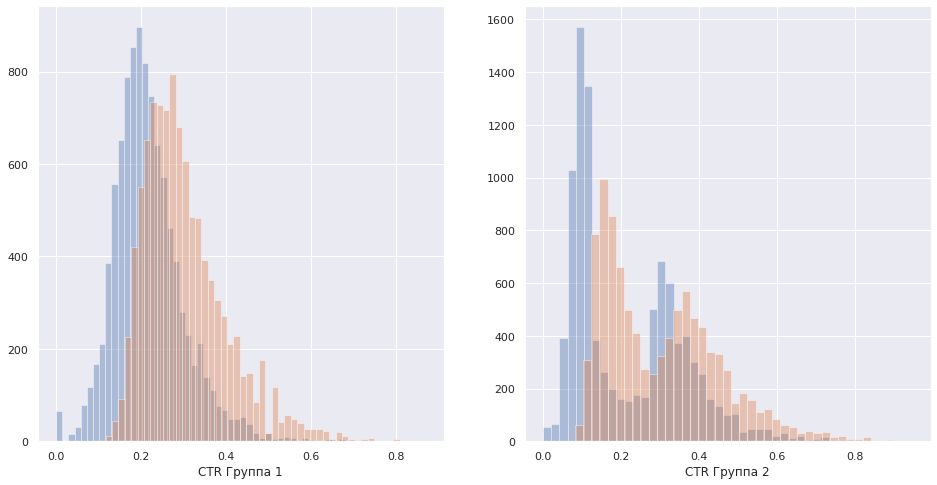

In [9]:
sns.set(rc={"figure.figsize": (16, 8)})
ax_1 = plt.subplot(1, 2, 1)
ax_1 = sns.distplot(group_1.ctr, kde=False)
ax_1 = sns.distplot(group_1.smothed_ctr, kde=False)
ax_1.set(xlabel="CTR Группа 1")

ax_2 = plt.subplot(1, 2, 2)
ax_2 = sns.distplot(group_2.ctr, kde=False)
ax_2 = sns.distplot(group_2.smothed_ctr, kde=False)
ax_2.set(xlabel="CTR Группа 2")

# Гистограмма ctr между группами

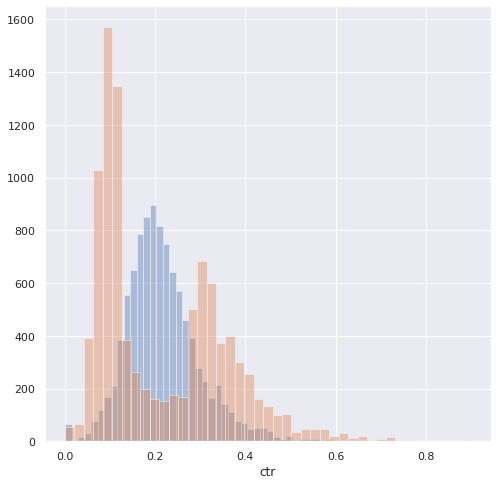

In [10]:
sns.set(rc={"figure.figsize": (8, 8)})

ax = sns.distplot(group_1.ctr, kde=False)
ax = sns.distplot(group_2.ctr, kde=False)


Видим, что распределения различаются. Но нельзя сказать , что одно смещенно относительно другого. 


Проведем анализ, с помощью статистических критериев

# t-test

In [26]:
from scipy.stats import ttest_ind
print('t-test')
print(ttest_ind(group_2.ctr, group_1.ctr,  equal_var = False))
print('\nt-test на сглаженном ctr')
print(ttest_ind(group_2.smothed_ctr, group_1.smothed_ctr,  equal_var = False))

t-test
Ttest_indResult(statistic=-0.4051491913112757, pvalue=0.685373331140751)

t-test на сглаженном ctr
Ttest_indResult(statistic=-0.7761549154109063, pvalue=0.43766815035447193)


В обоих случаях получили p-value больше , чем 0.05.

Следовательно, не можем отвергнуть нулевую гипотезу о равенстве средних. 

t-test говорит нам о том, нет статистически значимого отклонения, а значит ctr в группах не различается.


Однако, глядя на графики распределений видно, что распределение ctr группы 2 двухмодальное, оно НЕ симметричное, следовательное НЕ может иметь t-распределение Стьюдента. Поэтому мы не можем применять t-test.

# тест Манна-Уитни

In [12]:
from scipy.stats import mannwhitneyu
mannwhitneyu(group_2.ctr, group_1.ctr)

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)

In [22]:
from scipy.stats import mannwhitneyu
mannwhitneyu(group_2.smothed_ctr, group_1.smothed_ctr)

MannwhitneyuResult(statistic=45416075.0, pvalue=1.0039035004619023e-23)

p-value близко к нулю, а значит можем отвергнуть нулевую гипотезу на уровне значимости 0.05, что распределения случайных величин между выборками не различаются. 
Таким образом можно сказать, что ctr  в группах различаются.

# Пуассоновский бутстреп

In [14]:
from  scipy.stats import poisson
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2


<Axes: ylabel='Count'>

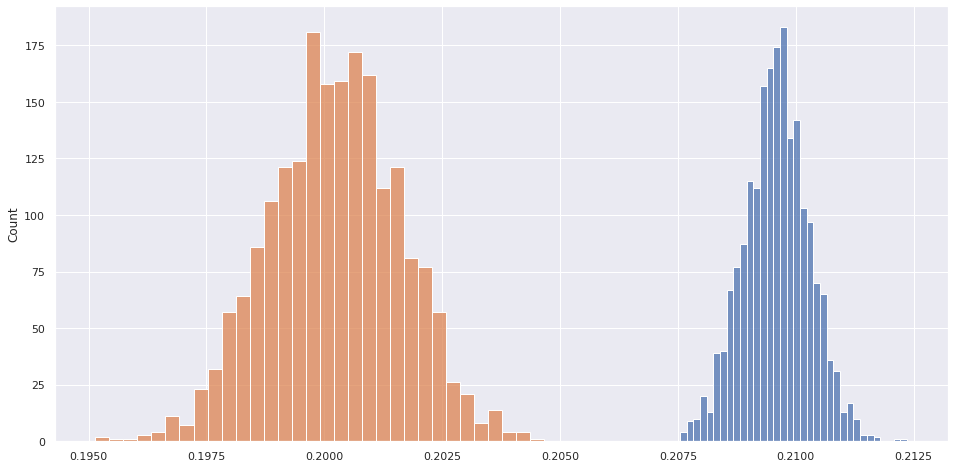

In [15]:
sns.set(rc={"figure.figsize": (16, 8)})
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2)

Бутстреп показывает, что в первой группе глобальный ctr значительно выше, чем в первой

<Axes: ylabel='Count'>

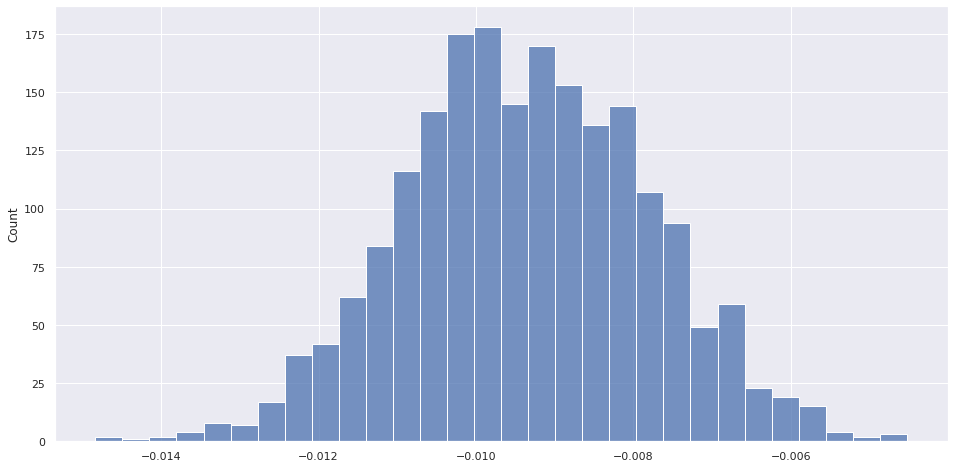

In [16]:
# посмотрим гистограмму разницы. Из тестовой группы вычтем контрольную
sns.histplot(ctr2-ctr1)

Получили отрицательные значения, что подтверждает тот факт, что в тестовой группе ctr ниже

# Бакетное преобразование

In [17]:
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2023-11-18' and '2023-11-24'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df1 = ph.read_clickhouse(q, connection=connection)
df1


,exp_group,bucket,bucket_ctr,ctr9
0,1,0,0.200592,0.305556
1,2,0,0.196510,0.385321
2,1,1,0.208799,0.311111
3,2,1,0.210375,0.485714
4,1,2,0.204632,0.314286
...,...,...,...,...
95,2,47,0.196808,0.428571
96,1,48,0.216369,0.320000
97,2,48,0.194780,0.400000
98,1,49,0.206288,0.333333


<Axes: xlabel='bucket_ctr', ylabel='Count'>

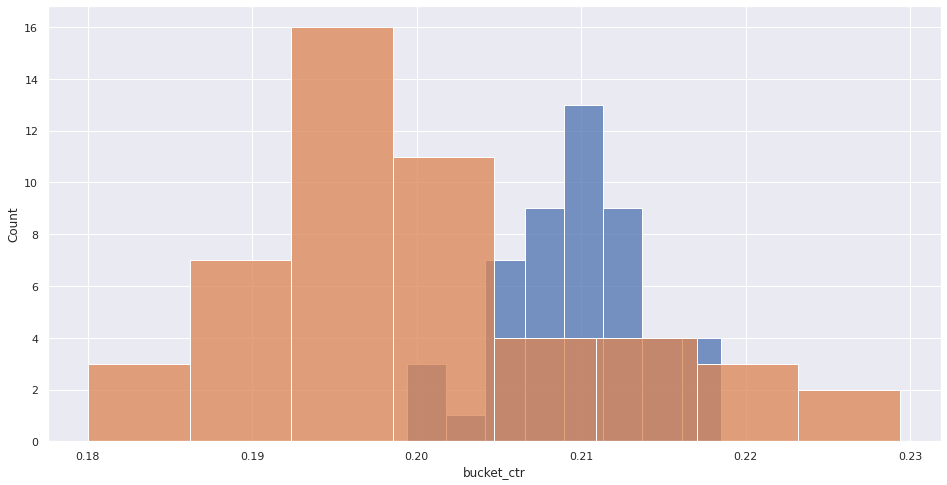

In [32]:
sns.histplot(df1[df1.exp_group == 1].bucket_ctr)
sns.histplot(df1[df1.exp_group == 2].bucket_ctr)

Распределения бакетного CTR похожи на нормальные

In [23]:
#Тест Манна-Уитни
mannwhitneyu(df1[df1.exp_group == 2].bucket_ctr, df1[df1.exp_group == 1].bucket_ctr)

MannwhitneyuResult(statistic=503.0, pvalue=2.6576427804010095e-07)

In [25]:
# t-тест

ttest_ind(df1[df1.exp_group == 2].bucket_ctr, df1[df1.exp_group == 1].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=-5.614819358149381, pvalue=4.592644937473873e-07)

Тесты t-test и Манна-Уитни поверх бакетного преобразования отвергают нулевую гипотезу.

# Выводы
Я бы не стала рекомендовать раскатывать новый алгоритм на всех пользователей. Тест пуассоновского бутстрепа говорит о том, что ctr в тестовой группе стал хуже. Из визуального анализа можно увидеть, что распределение группы 2 имеет два горба, пики которых находятся по разные стороны от пика распределения группы 1. Можно сделать вывод о том, что для каких-то пользователей новый алгоритм сработал лучше, чем старый, а для других пользователей новый алгоритм сработал хуже. Возможно стоить провести анализ пользователей, показавших лучшие и худшие результаты и на основе этих данных доработать алгоритм